In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "banana_dataset",  # Use the path to the extracted folder
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

# Verify the dataset
for images, labels in dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)

Found 3279 files belonging to 3 classes.
Batch shape: (32, 256, 256, 3)
Labels shape: (32,)


In [4]:
class_names = dataset.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Healthy Leaf',
 'Banana Panama Disease']

In [5]:
len(dataset)

103

In [38]:
import os
import collections

data_path = "banana_dataset"
class_counts = collections.Counter(os.listdir(data_path))
print(class_counts)


Counter({'Banana Black Sigatoka Disease': 1, 'Banana Healthy Leaf': 1, 'Banana Panama Disease': 1})


In [39]:
import os
from collections import Counter

# Define dataset path (Modify this if needed)
data_path = "banana_dataset"

# Get class names (folder names)
class_names = os.listdir(data_path)

# Count images in each class folder
image_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in class_names}

# Display results
print("Number of images per class:")
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")


Number of images per class:
Banana Black Sigatoka Disease: 1341
Banana Healthy Leaf: 1001
Banana Panama Disease: 937


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 0 1 0 1 1 2 2 0 0 1 1 0 2 2 0 2 0 1 1 1 1 0 1 0 0 2]


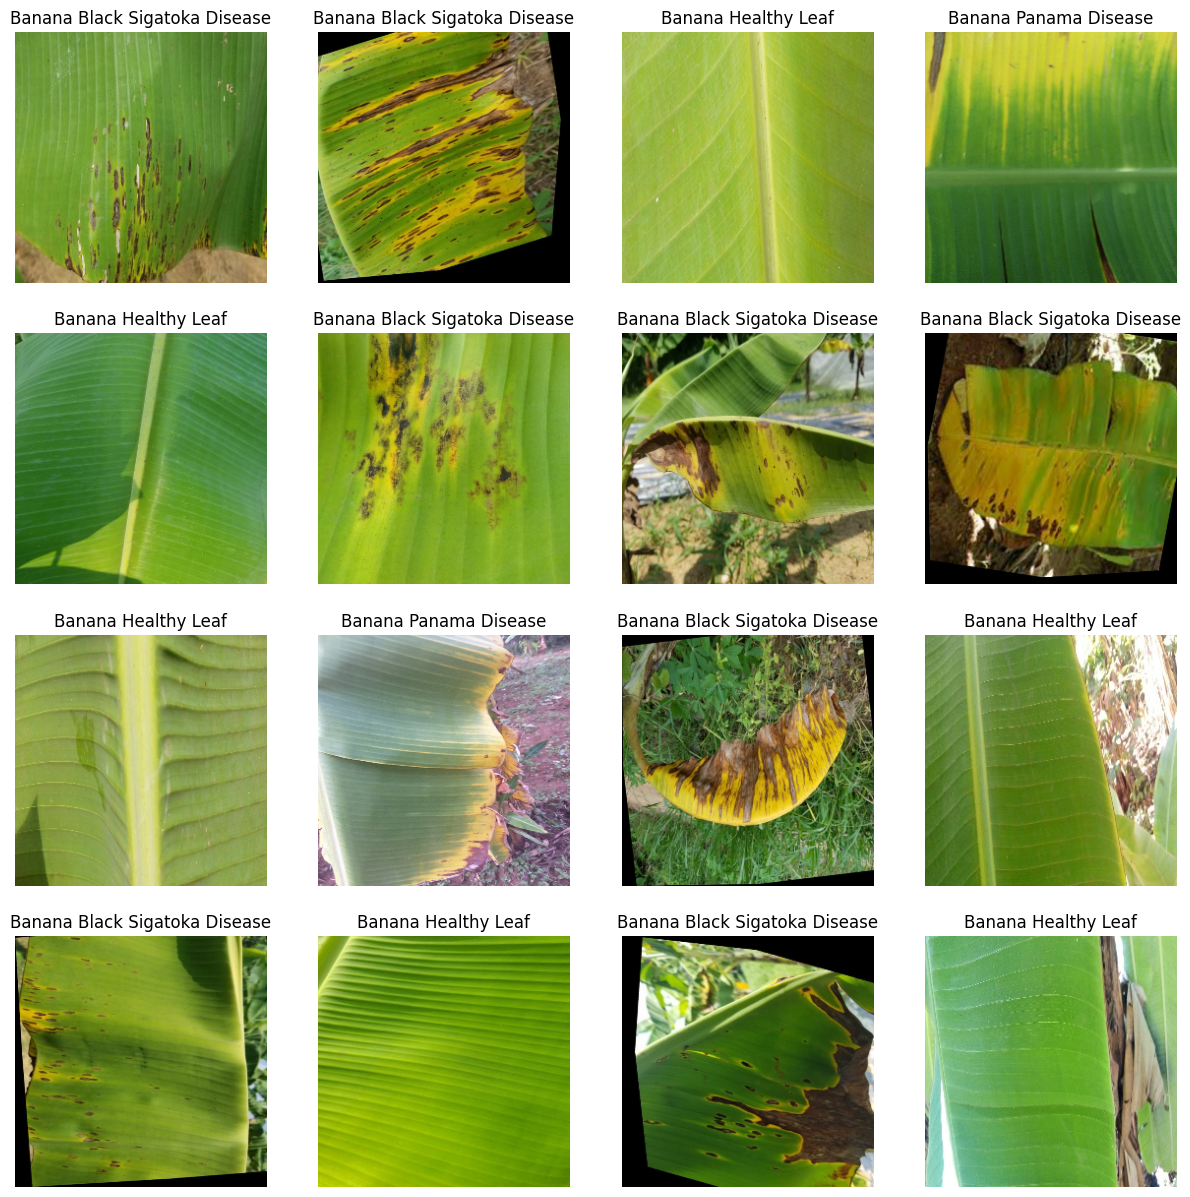

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) # Changed the grid to 4x4 to accommodate 16 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

82.4

In [9]:
train_ds = dataset.take(82)
len(train_ds)

82

In [10]:
test_ds = dataset.skip(82)
len(test_ds)

21

In [11]:
val_size=0.1
len(dataset)*val_size


10.3

In [12]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [13]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])



In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',  # Specifies the optimizer to use
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Specifies the loss function
    metrics=['accuracy']  # Specifies the metrics to monitor during training
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 52s 541ms/step - accuracy: 0.4104 - loss: 1.0577 - val_accuracy: 0.5688 - val_loss: 0.9431
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 602ms/step - accuracy: 0.5932 - loss: 0.8649 - val_accuracy: 0.7063 - val_loss: 0.6873
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 656ms/step - accuracy: 0.7372 - loss: 0.6365 - val_accuracy: 0.7312 - val_loss: 0.6342
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 742ms/step - accuracy: 0.7658 - loss: 0.5354 - val_accuracy: 0.8094 - val_loss: 0.4779
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 59s 720ms/step - accuracy: 0.8209 - loss: 0.4533 - val_accuracy: 0.8344 - val_loss: 0.4261
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 59s 715ms/step - accuracy: 0.8342 - loss: 0.4175 - val_accuracy: 0.7906 - val_loss: 0.4411
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 59s 715ms/step - accuracy: 0.8438 - loss: 0.3820 - val_accuracy: 0.8469 - val_loss: 0.3416
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 59s 715ms/step - accuracy: 0.8726 - loss: 0.3115 - val_accu

In [23]:
scores = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9838 - loss: 0.0797


In [24]:
scores

[0.07734977453947067, 0.9857954382896423]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 82}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

50

In [30]:
history.history['loss'][:5]

[1.0051699876785278,
 0.8013817071914673,
 0.6295968294143677,
 0.5079632997512817,
 0.45555081963539124]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

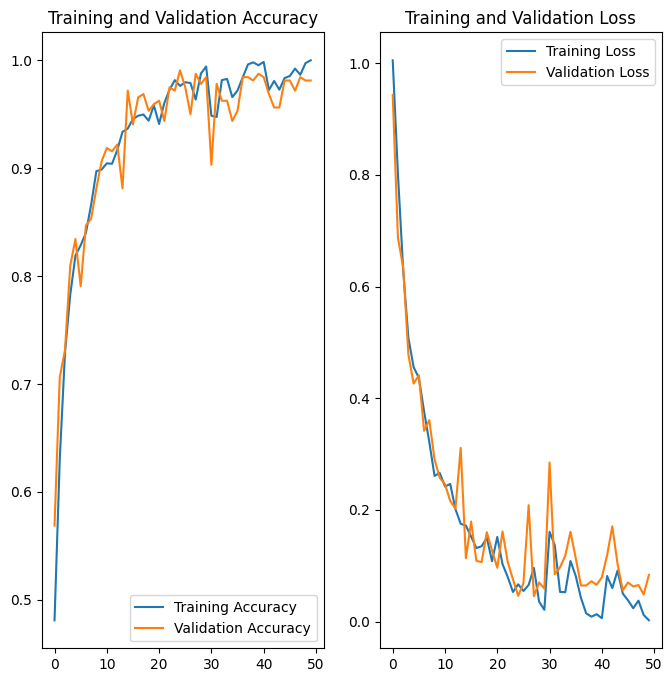

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

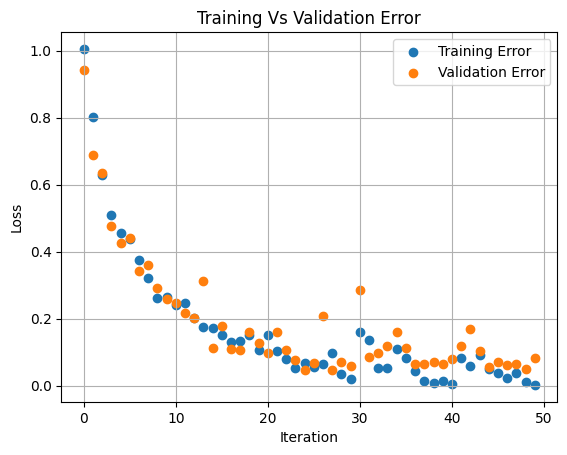

In [33]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

first image to predict
actual label: Banana Healthy Leaf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
predicted label: Banana Healthy Leaf


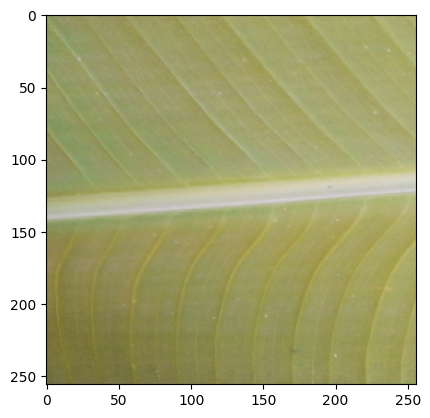

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


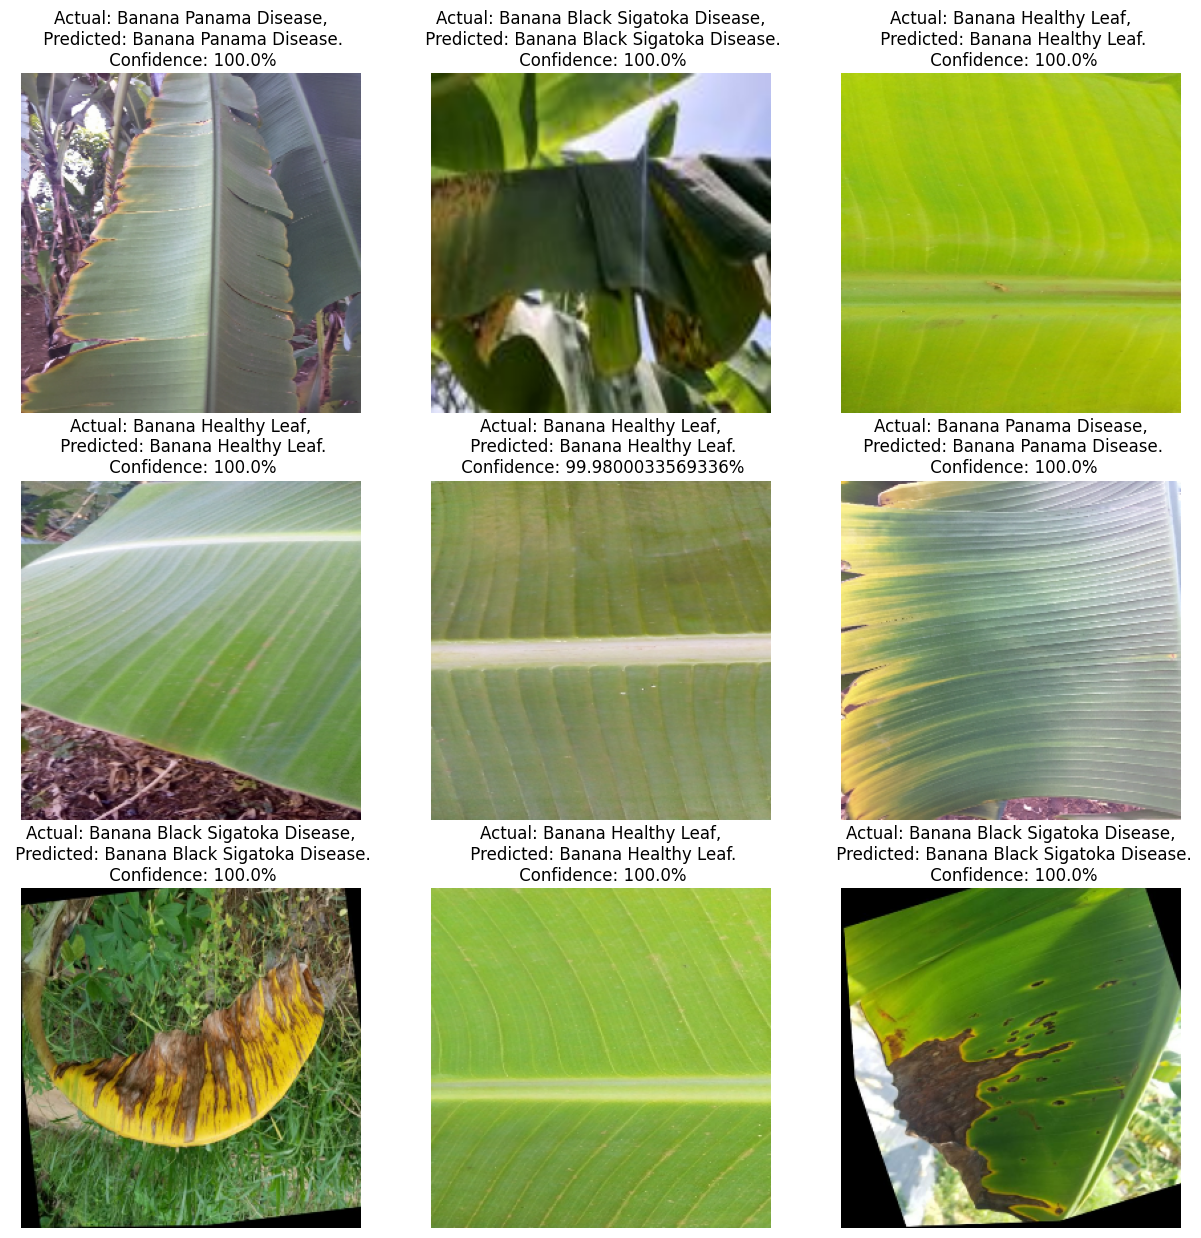

In [35]:
import numpy as np

def predict(model, image):
    """
    Predicts the class of an image using the given model.

    Args:
        model: The trained Keras model.
        image: The image to predict.

    Returns:
        A tuple containing the predicted class name and confidence score.
    """
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    confidence = round(100 * (np.max(prediction)), 2)
    predicted_class = class_names[predicted_class_index]

    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy()) # Call the defined 'predict' function
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [41]:
# Define the models directory
models_dir = "../saved_models/2"

# Ensure the directory exists
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model.save(f"{models_dir}/banana.keras")
print("Model saved successfully!")


Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


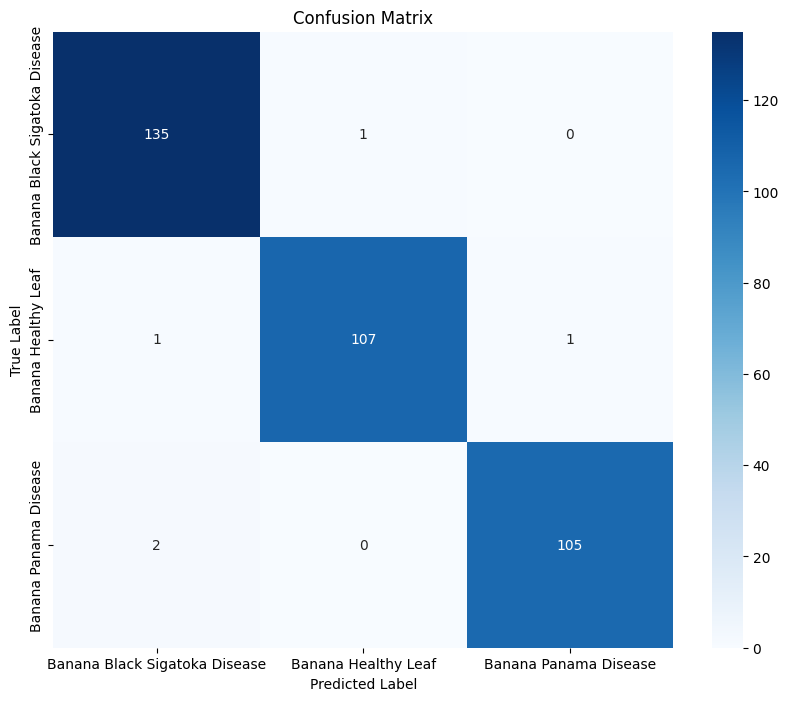

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
print("Raw Predictions:", predictions[0])  # Debugging


Raw Predictions: [9.9999952e-01 2.8809291e-07 2.0690028e-07]


In [42]:
import tensorflow as tf
import numpy as np

MODEL = tf.keras.models.load_model("../saved_models/1/banana.keras")
dummy_input = np.random.rand(1, 224, 224, 3)  # Adjust size if needed
output = MODEL.predict(dummy_input)
print("Model Output:", output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Model Output: [[2.5939206e-08 8.7813708e-11 1.0000000e+00]]


In [43]:
import numpy as np
dummy_input = np.random.rand(1, 256, 256, 3)
print("Test Output:", MODEL.predict(dummy_input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Test Output: [[2.4902421e-08 8.3312093e-11 1.0000000e+00]]


In [46]:
from PIL import Image
import numpy as np

image_path = "banana_dataset/Banana Healthy Leaf/20210218_154706.jpg"
image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
image = image.resize((224, 224))  # Resize to match model input
image = np.array(image) / 255.0  # Normalize
image = np.expand_dims(image, axis=0)  # Add batch dimension

output = model.predict(image)
print("Jupyter Output:", output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Jupyter Output: [[1.9705340e-08 2.4047852e-11 1.0000000e+00]]


In [47]:
import os
from collections import Counter

data_path = "banana_dataset"
class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in os.listdir(data_path)}
print("Dataset class distribution:", class_counts)


Dataset class distribution: {'Banana Black Sigatoka Disease': 1341, 'Banana Healthy Leaf': 1001, 'Banana Panama Disease': 937}
